In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet


from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter    

sns.set_style('whitegrid')

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=["date"])
test_df = pd.read_csv('test.csv', parse_dates=["date"])

train_df.head()

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

In [3]:
def show_valuecounts(df, column_name, sort_by_column_name=False):
    value_count = df[column_name].value_counts().reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(normalize=True)*100
    value_count = value_count.reset_index()
    if sort_by_column_name:
        value_count = value_count.sort_values(column_name)
    plt.rcParams['font.size'] = '16'
    value_count.set_index(column_name).plot.pie(y="Value Count", figsize=(8,8), legend=False, ylabel="");

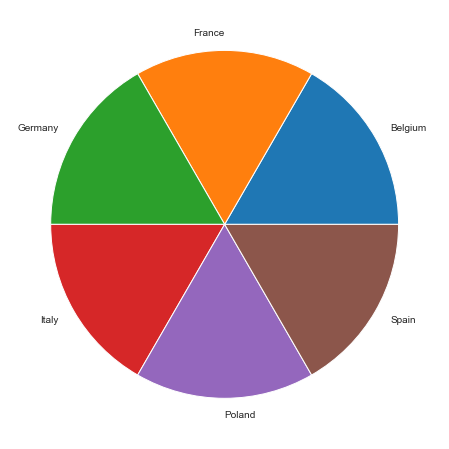

In [4]:
show_valuecounts(train_df, "country")

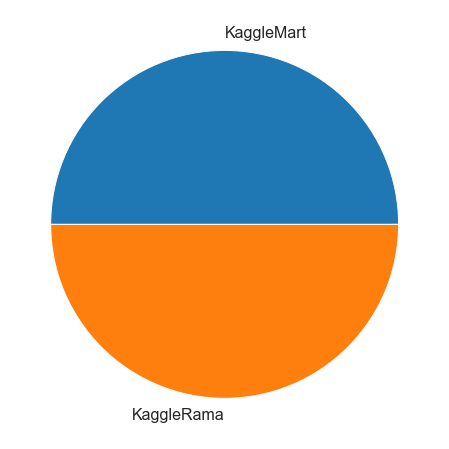

In [5]:
show_valuecounts(train_df, "store")

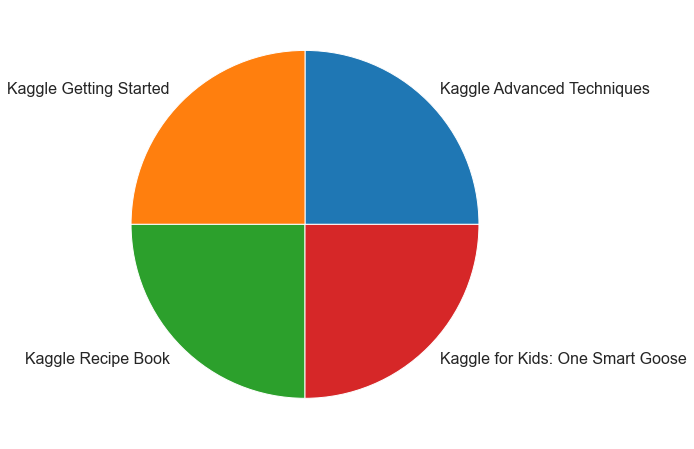

In [6]:
show_valuecounts(train_df, "product")

In [7]:
train_df.groupby(["country","store","product"])["num_sold"].count().value_counts() ### All groups have equal length of 1461 days

1461    48
Name: num_sold, dtype: int64

# Products

In [8]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
product_df.head(8)

date                           product  num_sold
0 2017-01-01        Kaggle Advanced Techniques      4267
1 2017-01-01            Kaggle Getting Started      3492
2 2017-01-01                Kaggle Recipe Book      2900
3 2017-01-01  Kaggle for Kids: One Smart Goose      4693
4 2017-01-02        Kaggle Advanced Techniques      3242
5 2017-01-02            Kaggle Getting Started      2597
6 2017-01-02                Kaggle Recipe Book      2119
7 2017-01-02  Kaggle for Kids: One Smart Goose      3620

In [9]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(), axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(8)

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693
4 2017-01-02        Kaggle Advanced Techniques  0.280014
5 2017-01-02            Kaggle Getting Started  0.224305
6 2017-01-02                Kaggle Recipe Book  0.183020
7 2017-01-02  Kaggle for Kids: One Smart Goose  0.312662

<AxesSubplot:xlabel='date', ylabel='ratios'>

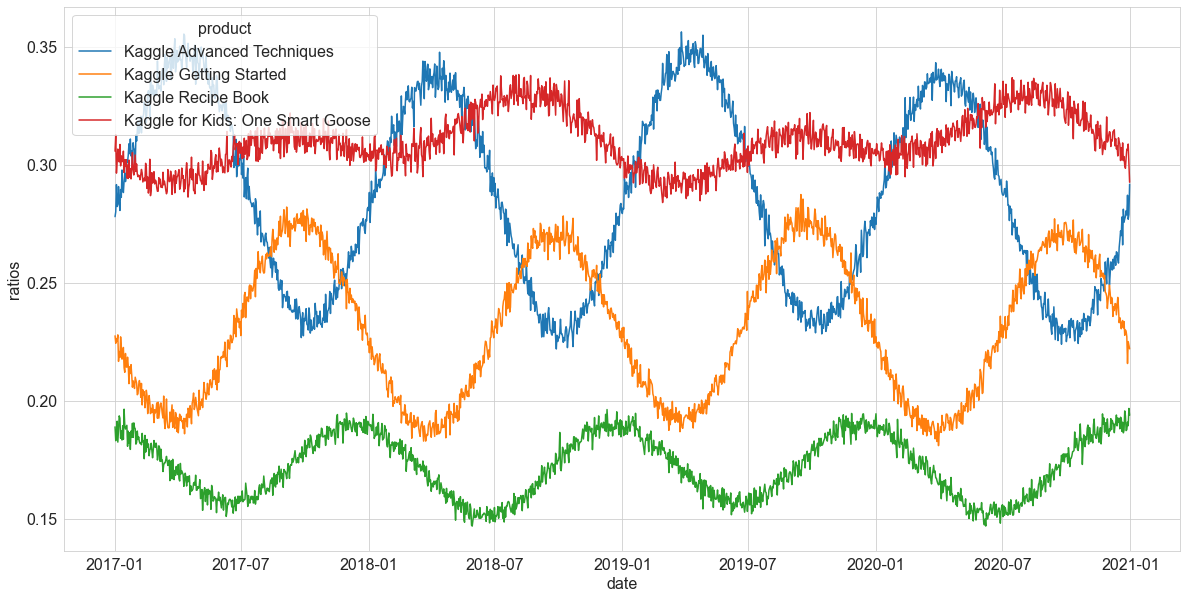

In [10]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product")

<AxesSubplot:xlabel='date', ylabel='ratios'>

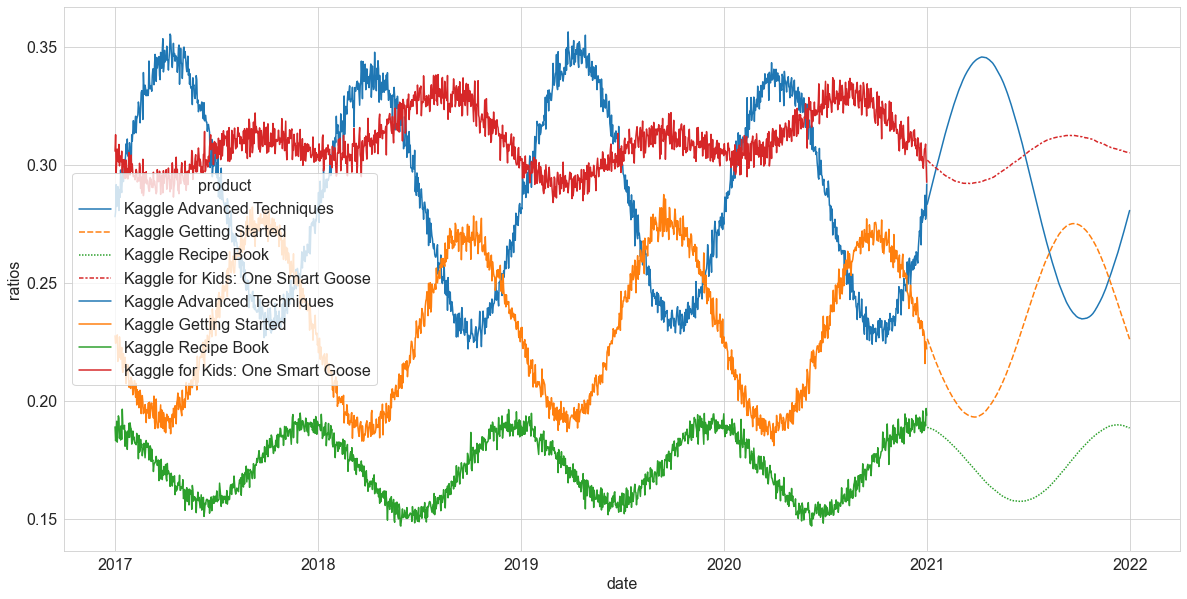

In [11]:
test_product_ratio_df = pd.DataFrame(index=test_df.date.unique())

### We use savgol_filter from SciPy to smooth the data of 2019 and apply it as a 2021 model

for prod in product_ratio_df['product'].unique():
    y = product_ratio_df[product_ratio_df['product']==prod].ratios.values
    test_product_ratio_df[prod] = savgol_filter(y, window_length=200, polyorder=3)[730:1095]

f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=test_product_ratio_df)
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product")

In [12]:
test_product_ratio_df.sum(axis=1).value_counts() ### Weights are normalized

1.0    131
1.0     91
1.0     86
1.0     35
1.0     13
1.0      6
1.0      3
dtype: int64

# Countries

In [13]:
country_ratio_df = (train_df.groupby(["date","country"])["num_sold"].sum() / \
                    train_df.groupby(["date"])["num_sold"].sum()).reset_index() \
                    .rename({'num_sold': 'ratios'}, axis=1)
country_ratio_df.head(12)

date  country    ratios
0  2017-01-01  Belgium  0.216258
1  2017-01-01   France  0.191441
2  2017-01-01  Germany  0.223880
3  2017-01-01    Italy  0.158351
4  2017-01-01   Poland  0.069958
5  2017-01-01    Spain  0.140112
6  2017-01-02  Belgium  0.218086
7  2017-01-02   France  0.188461
8  2017-01-02  Germany  0.222318
9  2017-01-02    Italy  0.159613
10 2017-01-02   Poland  0.069442
11 2017-01-02    Spain  0.142080

Text(0, 0.5, 'Proportion of sales')

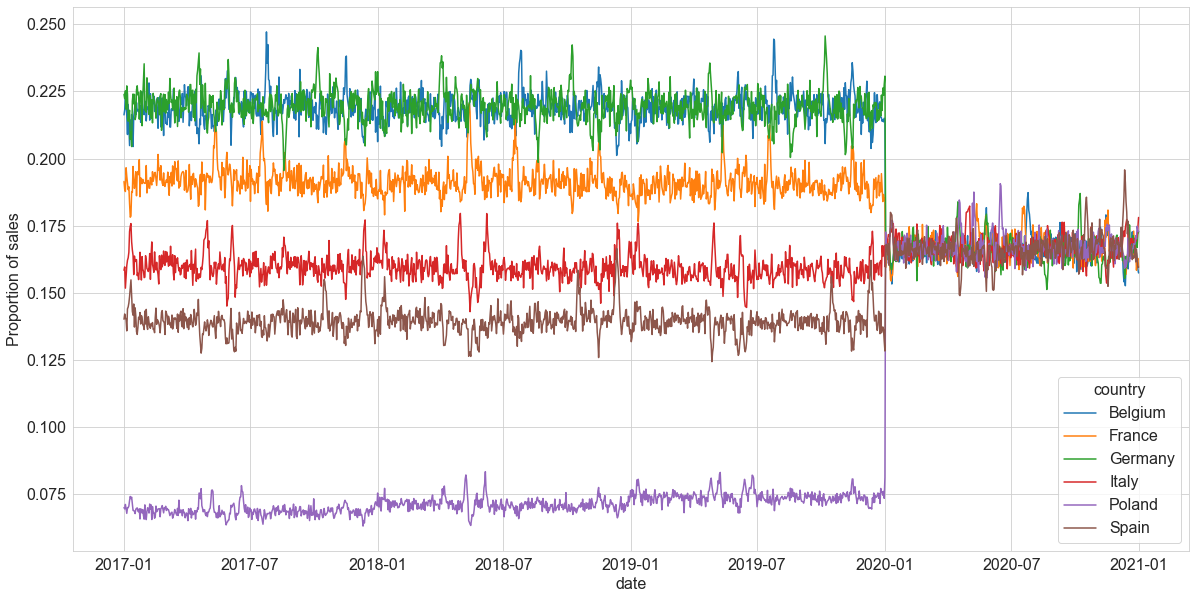

In [14]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = country_ratio_df, x="date", y="ratios", hue="country")
ax.set_ylabel("Proportion of sales")

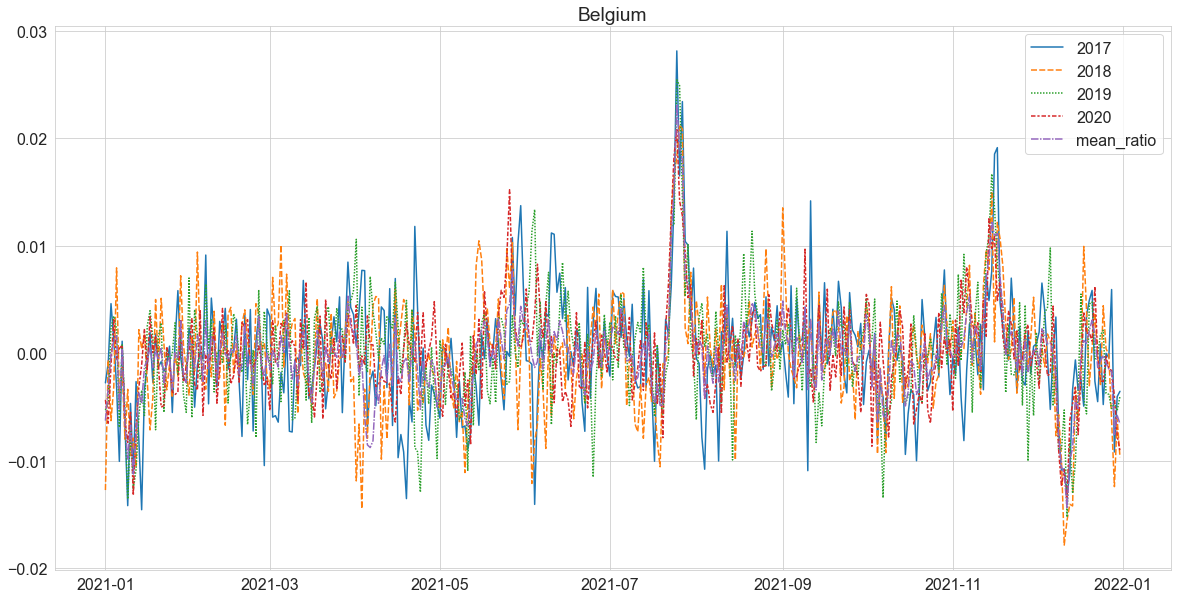

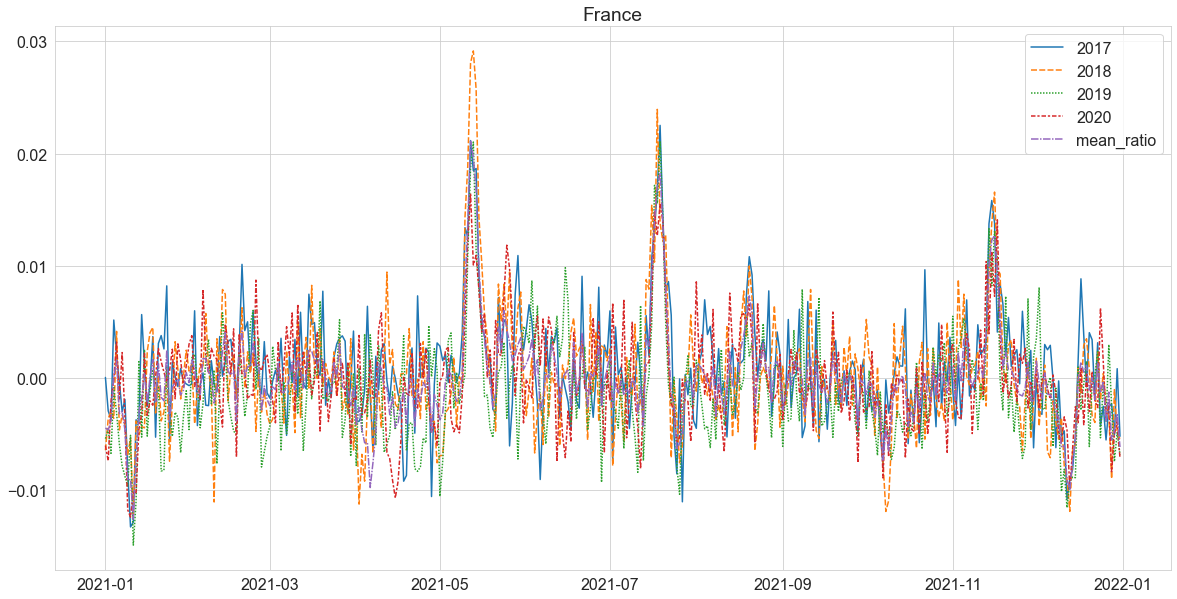

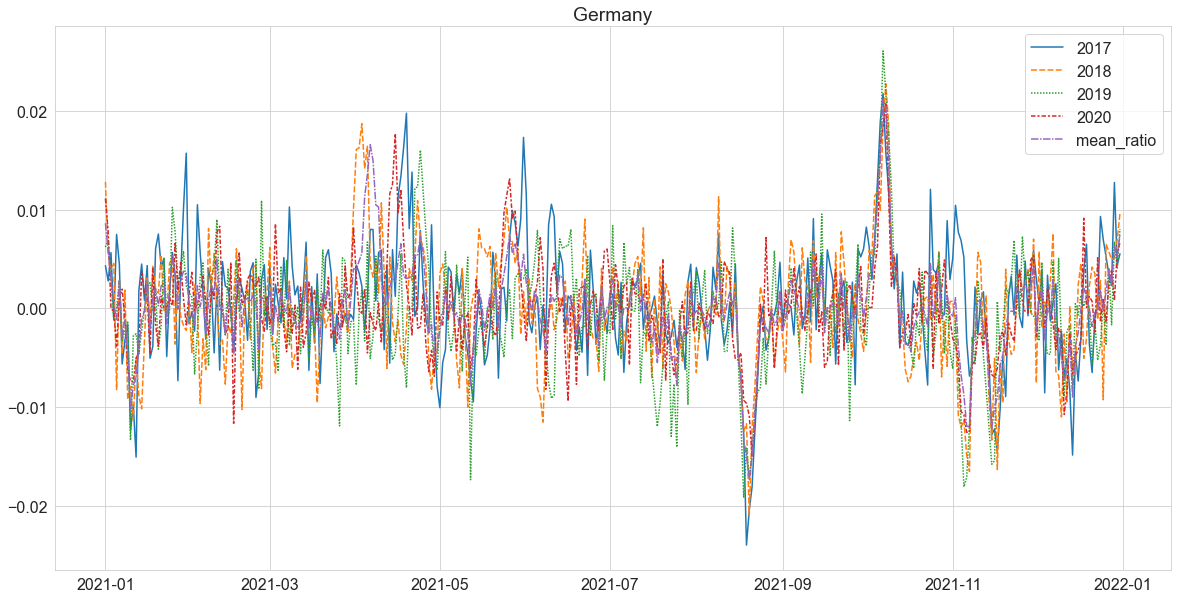

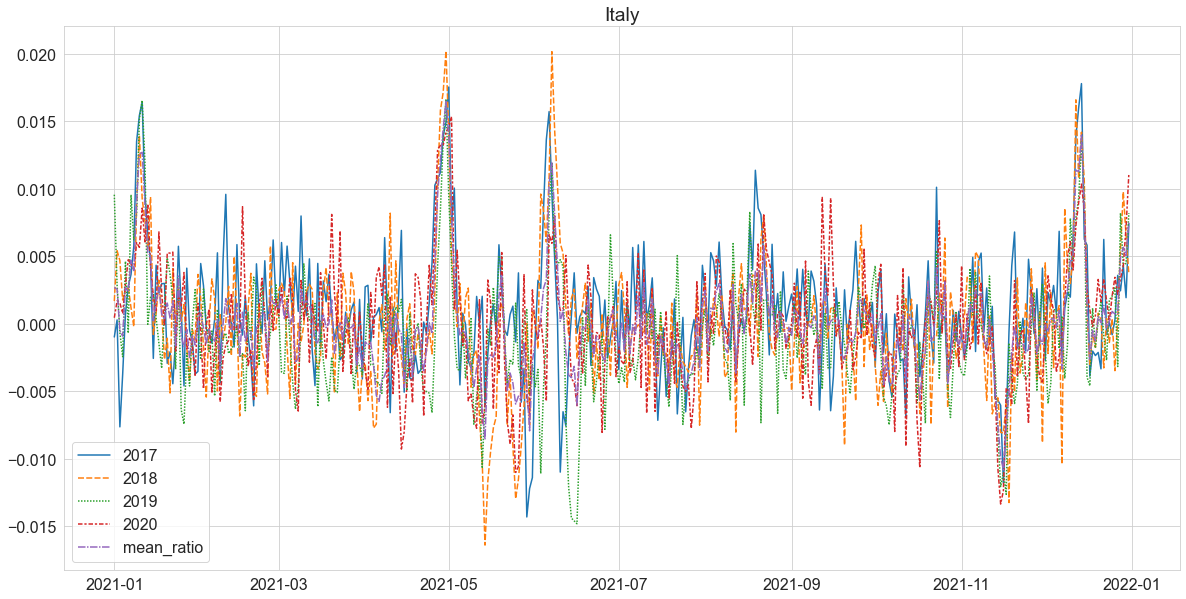

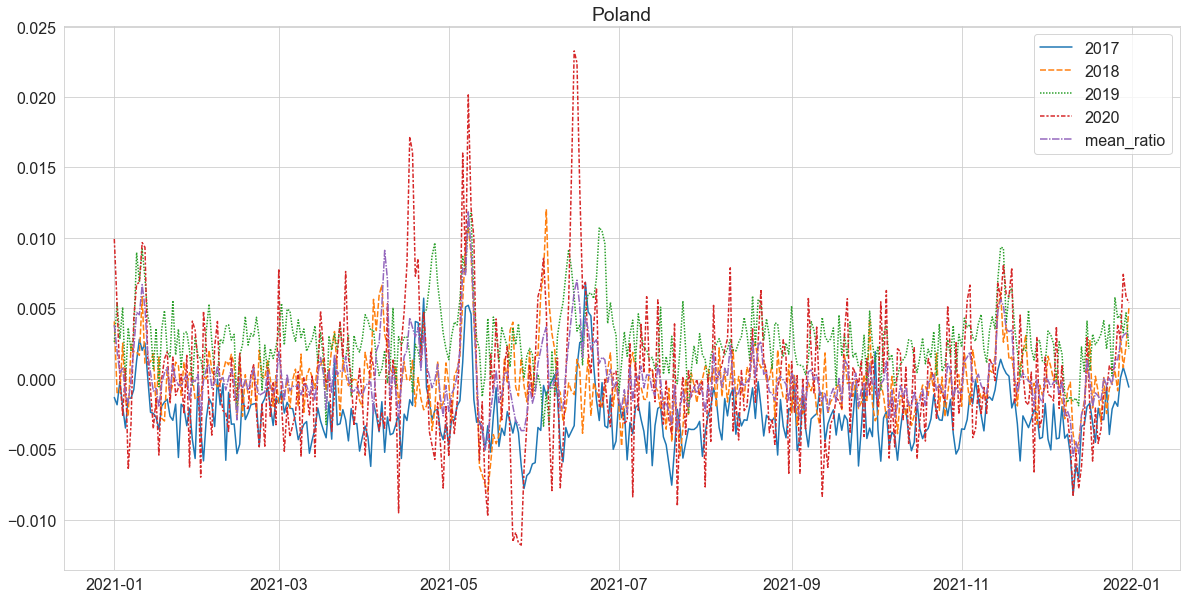

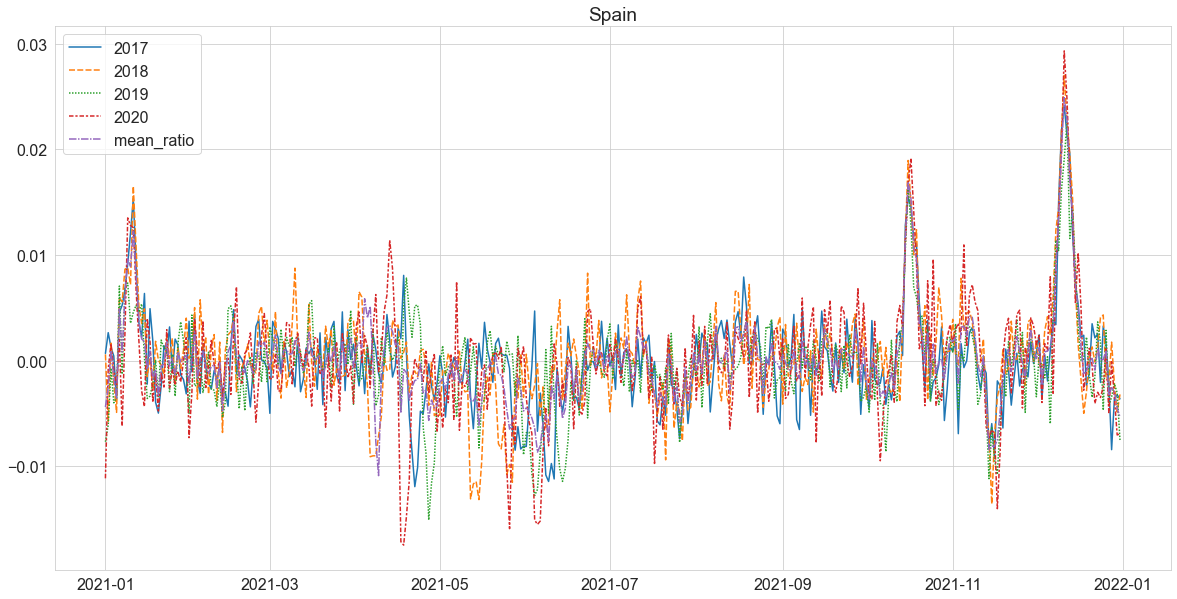

In [15]:
test_country_ratio_df = pd.DataFrame(index=test_df.date.unique())

for country in country_ratio_df.country.unique():
    country_df = country_ratio_df[country_ratio_df.country==country].reset_index(drop=True)[['date','ratios']]
    country_df['year'] = country_df.date.dt.year

    df = pd.DataFrame(index=np.arange(365))
    bfr2020mean = country_df.loc[:1095].ratios.mean()
    aft2020mean = country_df.loc[1096:].ratios.mean()
    df['2017'] = country_df[country_df.year==2017].ratios.values - bfr2020mean
    df['2018'] = country_df[country_df.year==2018].ratios.values - bfr2020mean
    df['2019'] = country_df[country_df.year==2019].ratios.values - bfr2020mean
    before29 = country_df[country_df.year==2020].loc[1095:1153].ratios.values
    after29 = country_df[country_df.year==2020].loc[1155:].ratios.values
    df['2020'] = np.concatenate([before29, after29])
    df['2020'][0] = df['2020'][0] - bfr2020mean
    df['2020'][1:] = df['2020'][1:] - aft2020mean
    df['mean_ratio'] = df.mean(axis=1)
    df = df.set_index(test_df.date.unique())

    ### Germany peaks in April varied, so it means that it depended on Easter dates
    ger_easter = (df['2017']['2021-04-16':'2021-04-21'].reset_index(drop=True) + \
                  df['2018']['2021-03-31':'2021-04-05'].reset_index(drop=True) + \
                  df['2019']['2021-04-22':'2021-04-27'].reset_index(drop=True) + \
                  df['2020']['2021-04-13':'2021-04-18'].reset_index(drop=True)) / 4
    df['mean_ratio']['2021-04-04':'2021-04-09'] = ger_easter.values
    
    test_country_ratio_df[country] = df['mean_ratio'] + 1/6
    
    f, ax = plt.subplots(figsize=(20,10))
    ax.set_title(country)
    sns.lineplot(data=df)

<AxesSubplot:>

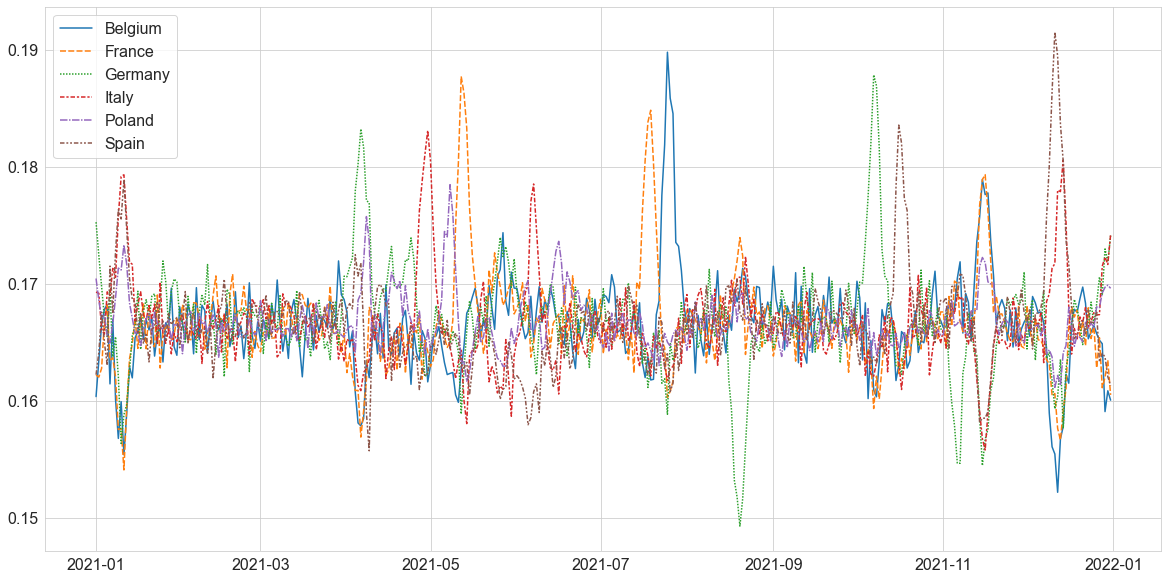

In [16]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=test_country_ratio_df)

We replace all dates to 1/6 except those corresponding to holidays

<AxesSubplot:>

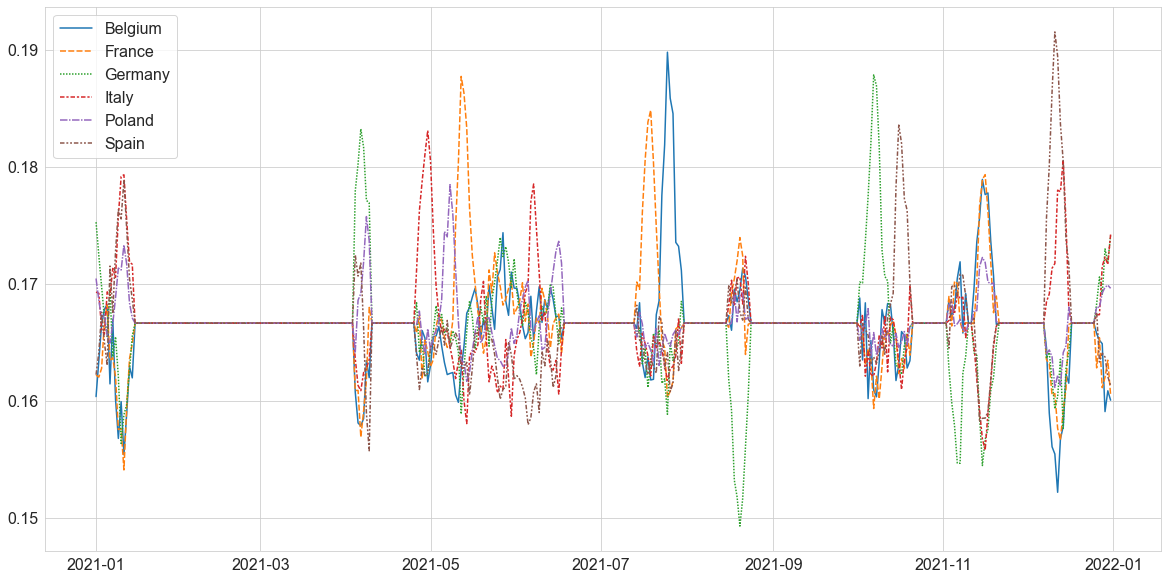

In [17]:
test_country_ratio_df.loc['2021-01-15':'2021-04-03'] = 1/6
test_country_ratio_df.loc['2021-04-10':'2021-04-25'] = 1/6
test_country_ratio_df.loc['2021-06-18':'2021-07-13'] = 1/6
test_country_ratio_df.loc['2021-07-31':'2021-08-15'] = 1/6
test_country_ratio_df.loc['2021-08-24':'2021-10-01'] = 1/6
test_country_ratio_df.loc['2021-10-21':'2021-11-02'] = 1/6
test_country_ratio_df.loc['2021-11-10':'2021-11-11'] = 1/6
test_country_ratio_df.loc['2021-11-21':'2021-12-07'] = 1/6
test_country_ratio_df.loc['2021-12-17':'2021-12-25'] = 1/6

f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=test_country_ratio_df)

# Stores

In [18]:
store_ratio_df = (train_df.groupby(["date","store"])["num_sold"].sum() / \
                    train_df.groupby(["date"])["num_sold"].sum()).reset_index() \
                    .rename({'num_sold': 'ratios'}, axis=1)
store_ratio_df.head(4)

date       store    ratios
0 2017-01-01  KaggleMart  0.736972
1 2017-01-01  KaggleRama  0.263028
2 2017-01-02  KaggleMart  0.739679
3 2017-01-02  KaggleRama  0.260321

Text(0, 0.5, 'Proportion of sales')

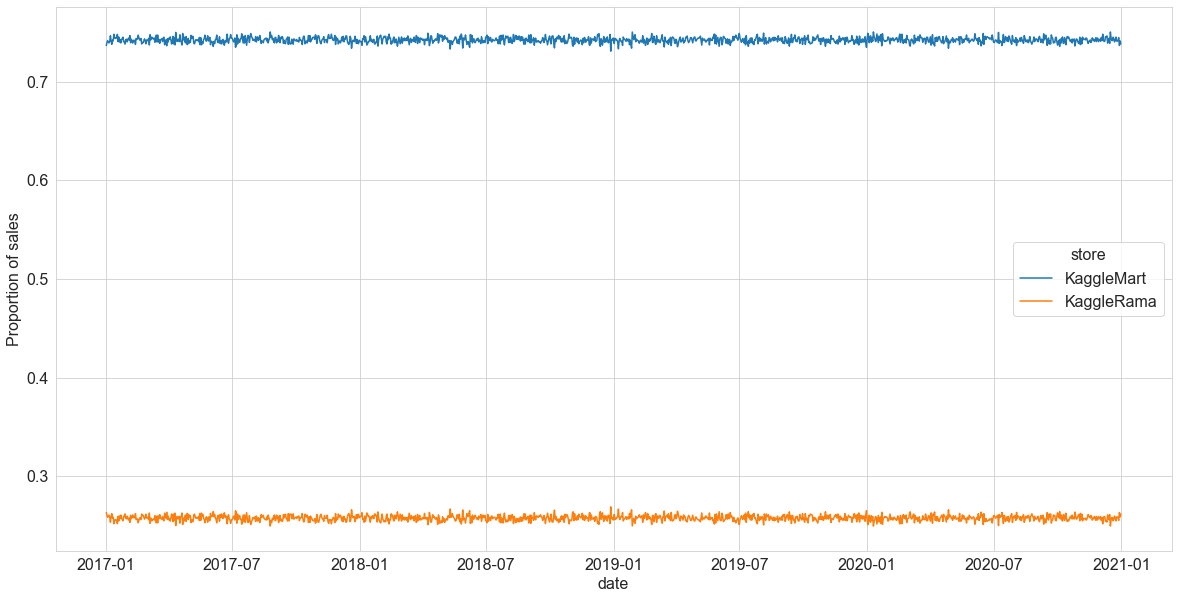

In [19]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = store_ratio_df, x="date", y="ratios", hue="store");
ax.set_ylabel("Proportion of sales")

In [20]:
store_weights = train_df.groupby("store")["num_sold"].sum() / train_df["num_sold"].sum()
store_weights ### Constant ratios

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

# Agg time-series to predict

In [21]:
agg_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()
agg_df.head(8)

date  num_sold
0 2017-01-01     15352
1 2017-01-02     11578
2 2017-01-03     10884
3 2017-01-04     10445
4 2017-01-05      9795
5 2017-01-06      9883
6 2017-01-07     10271
7 2017-01-08     10365

<AxesSubplot:xlabel='date', ylabel='num_sold'>

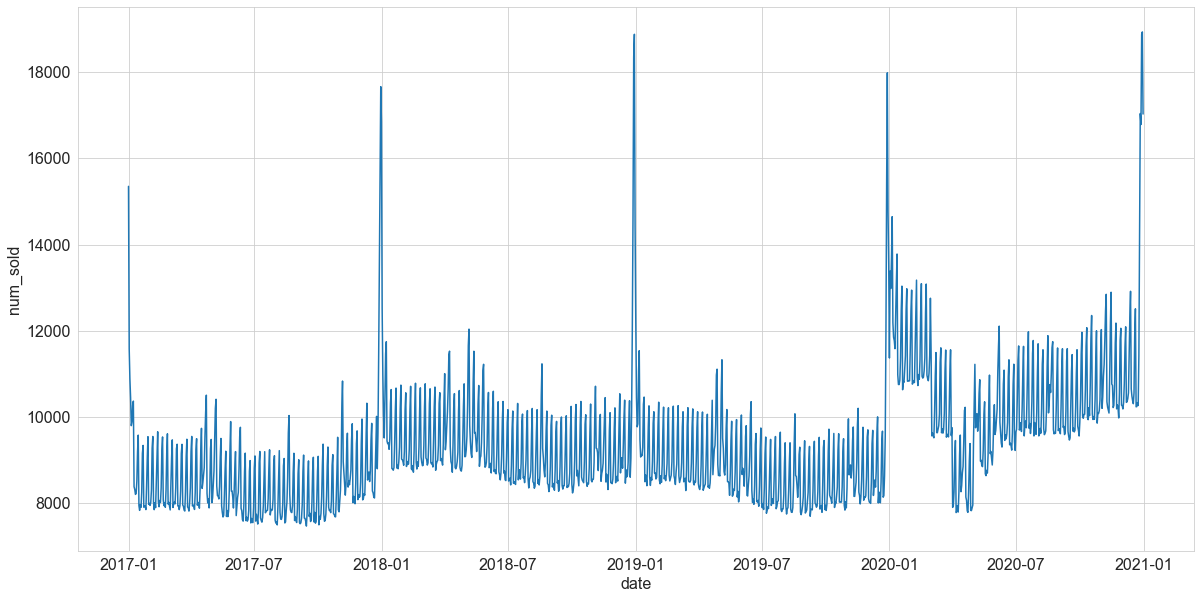

In [22]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = agg_df, x="date", y="num_sold")

# STATSMODELS

In [23]:
seasonal_decomp17 = seasonal_decompose(agg_df.loc[:364].set_index('date'), model="additive")
seasonal_decomp18 = seasonal_decompose(agg_df.loc[365:729].set_index('date'), model="additive")
seasonal_decomp19 = seasonal_decompose(agg_df.loc[730:1094].set_index('date'), model="additive")
seasonal_decomp20 = seasonal_decompose(agg_df.loc[1095:].set_index('date'), model="additive")
exc_weekly17 = seasonal_decomp17.observed - seasonal_decomp17.seasonal
exc_weekly18 = seasonal_decomp18.observed - seasonal_decomp18.seasonal
exc_weekly19 = seasonal_decomp19.observed - seasonal_decomp19.seasonal
exc_weekly20 = seasonal_decomp20.observed - seasonal_decomp20.seasonal

<AxesSubplot:title={'center':'Exclude Weekly 2017'}, xlabel='date'>

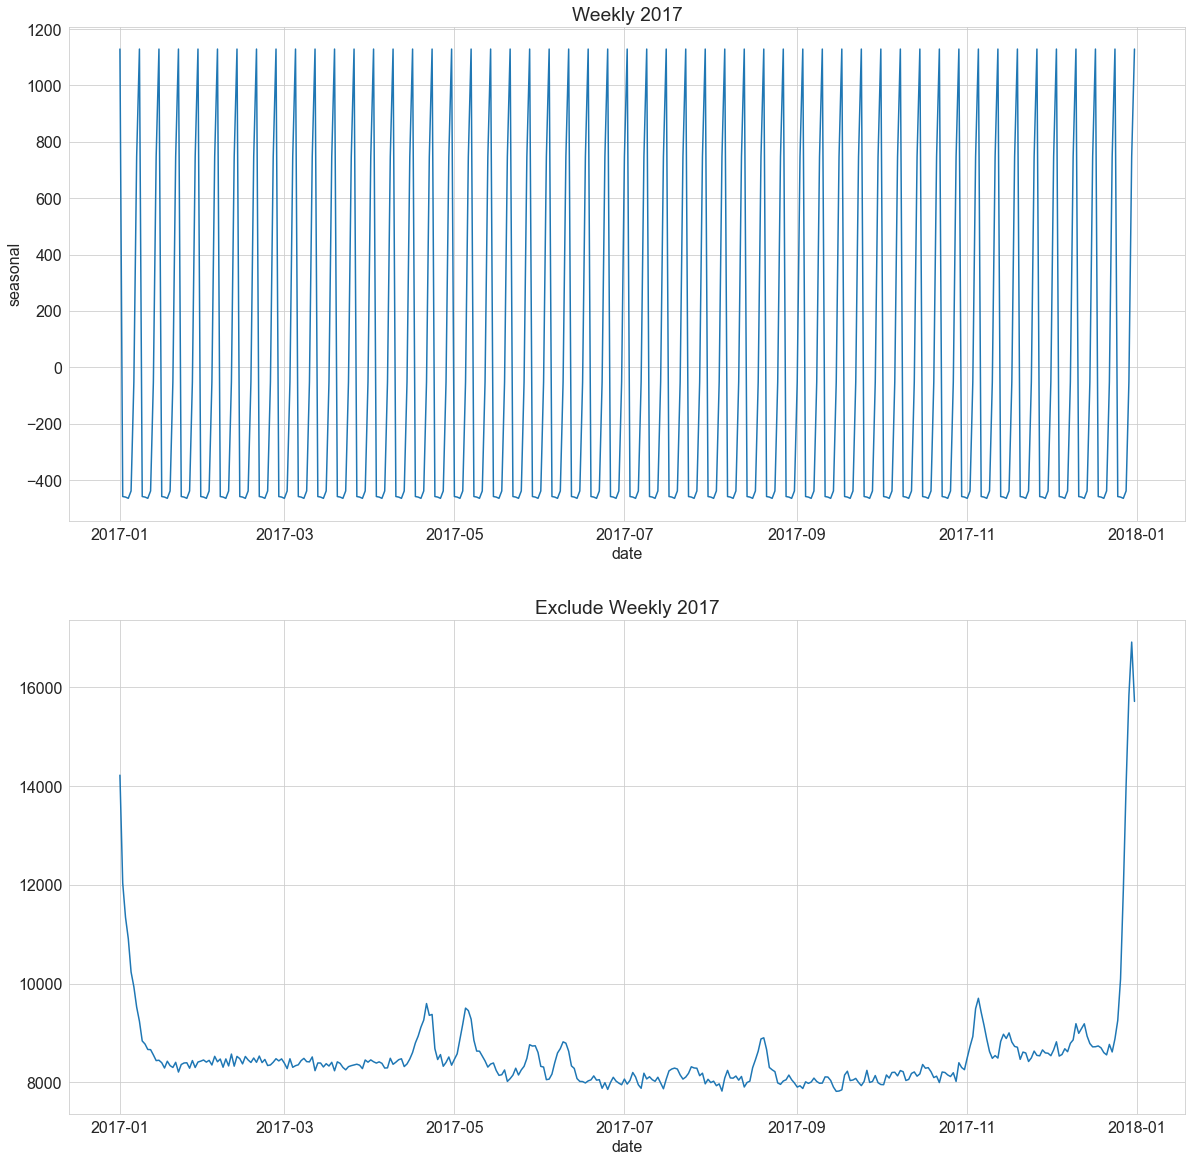

In [24]:
f, ax = plt.subplots(2, 1, figsize=(20,20))
ax[0].set_title('Weekly 2017')
ax[1].set_title('Exclude Weekly 2017')
sns.lineplot(ax=ax[0], data = seasonal_decomp17.seasonal, x="date", y=seasonal_decomp17.seasonal)
sns.lineplot(ax=ax[1], data = exc_weekly17, x="date", y=exc_weekly17)

<AxesSubplot:title={'center':'Exclude Weekly 2018'}, xlabel='date'>

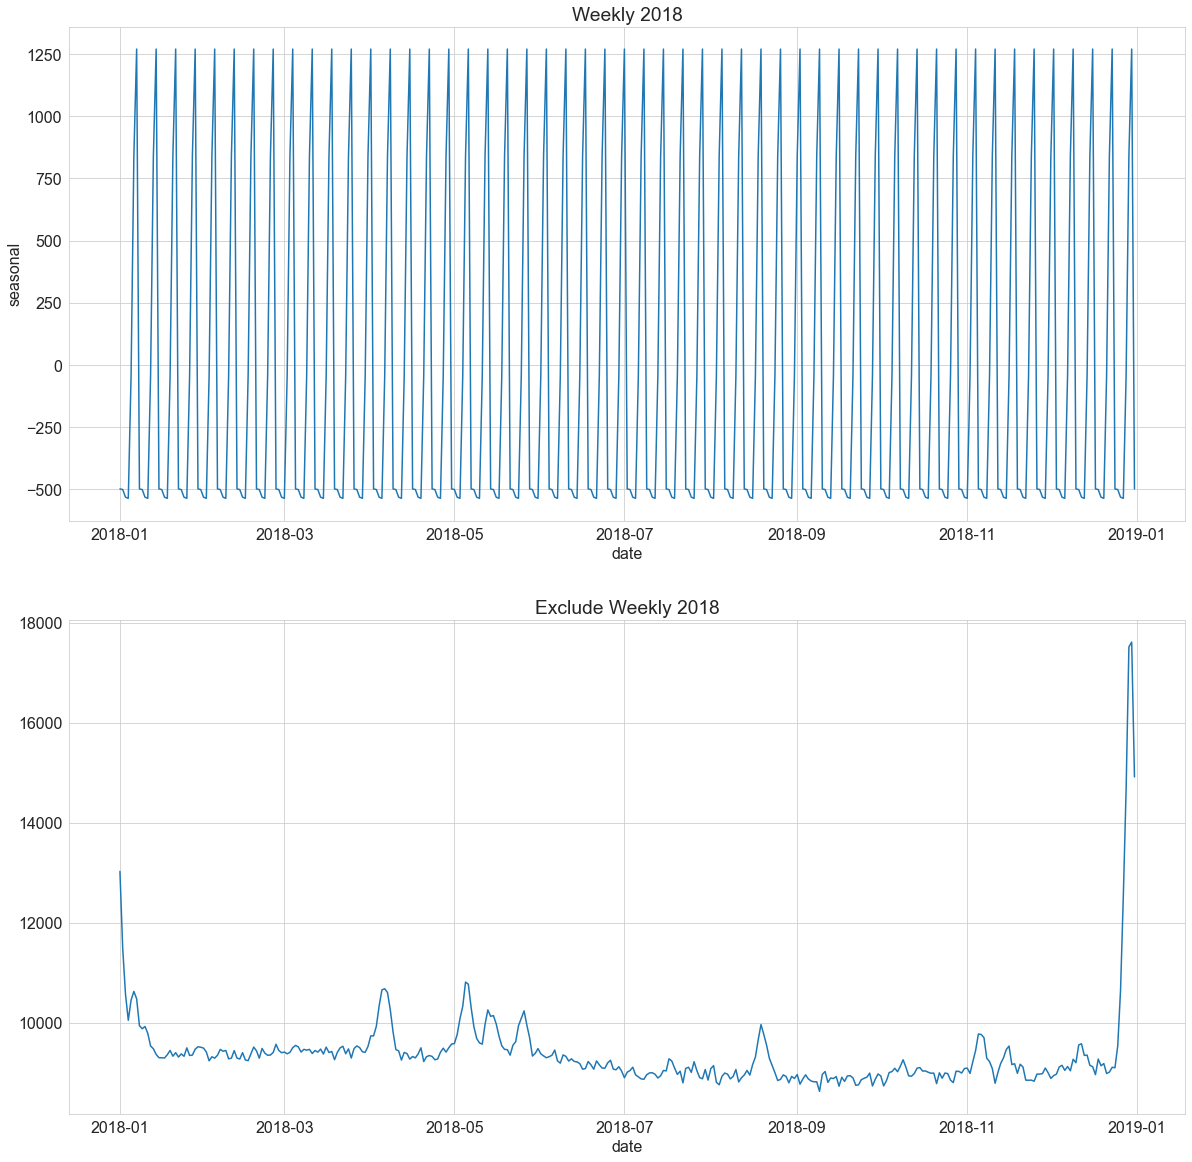

In [25]:
f, ax = plt.subplots(2, 1, figsize=(20,20))
ax[0].set_title('Weekly 2018')
ax[1].set_title('Exclude Weekly 2018')
sns.lineplot(ax=ax[0], data = seasonal_decomp18.seasonal, x="date", y=seasonal_decomp18.seasonal)
sns.lineplot(ax=ax[1], data = exc_weekly18, x="date", y=exc_weekly18)

<AxesSubplot:title={'center':'Exclude Weekly 2019'}, xlabel='date'>

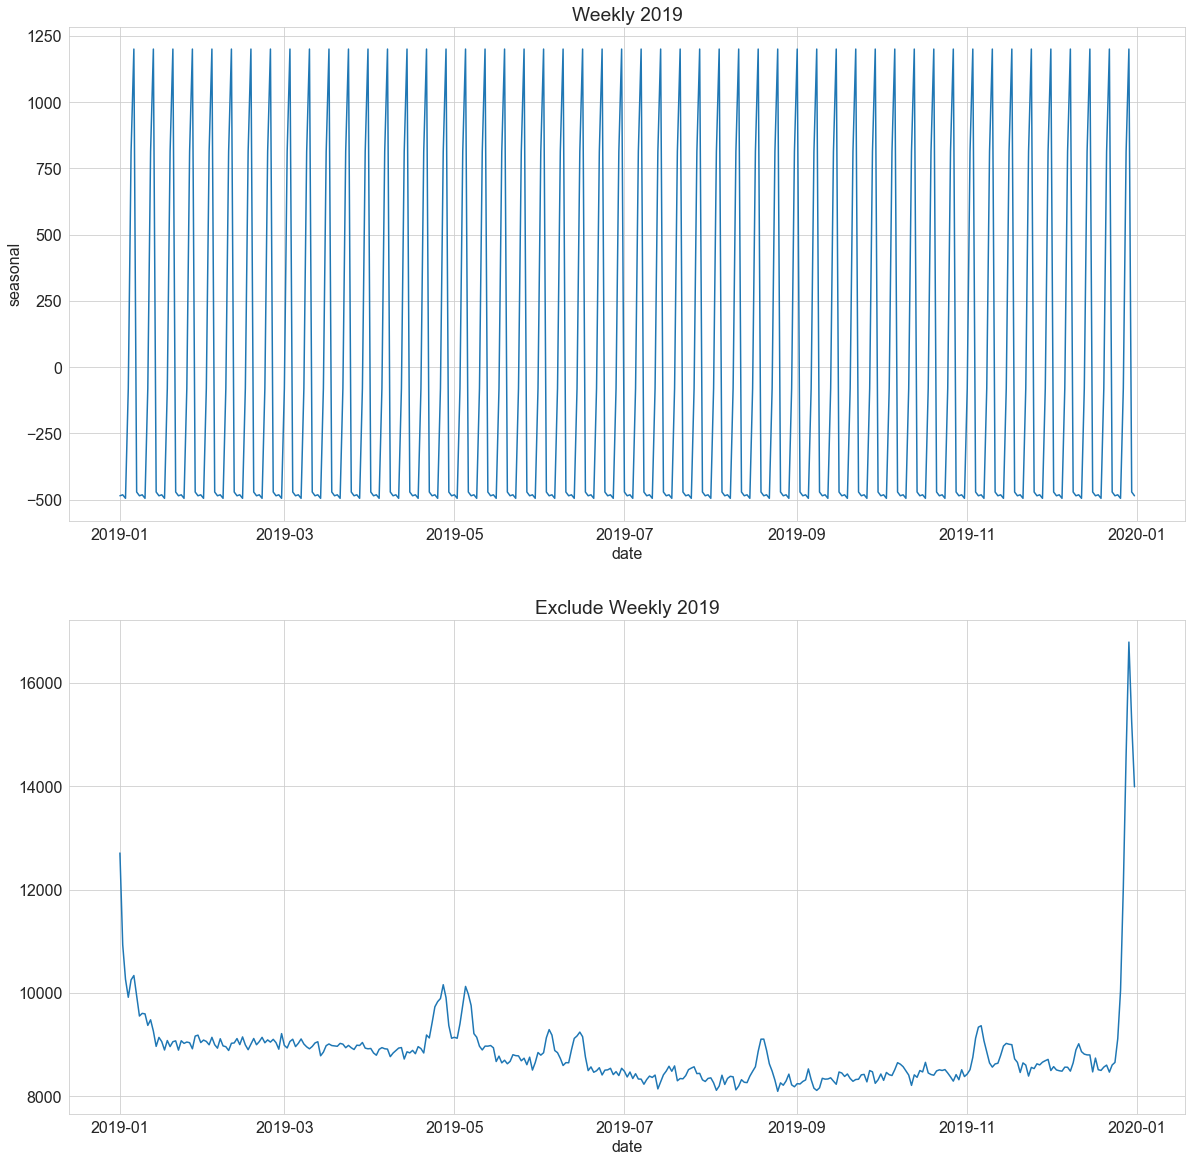

In [26]:
f, ax = plt.subplots(2, 1, figsize=(20,20))
ax[0].set_title('Weekly 2019')
ax[1].set_title('Exclude Weekly 2019')
sns.lineplot(ax=ax[0], data = seasonal_decomp19.seasonal, x="date", y=seasonal_decomp19.seasonal)
sns.lineplot(ax=ax[1], data = exc_weekly19, x="date", y=exc_weekly19)

<AxesSubplot:title={'center':'Exclude Weekly 2020'}, xlabel='date'>

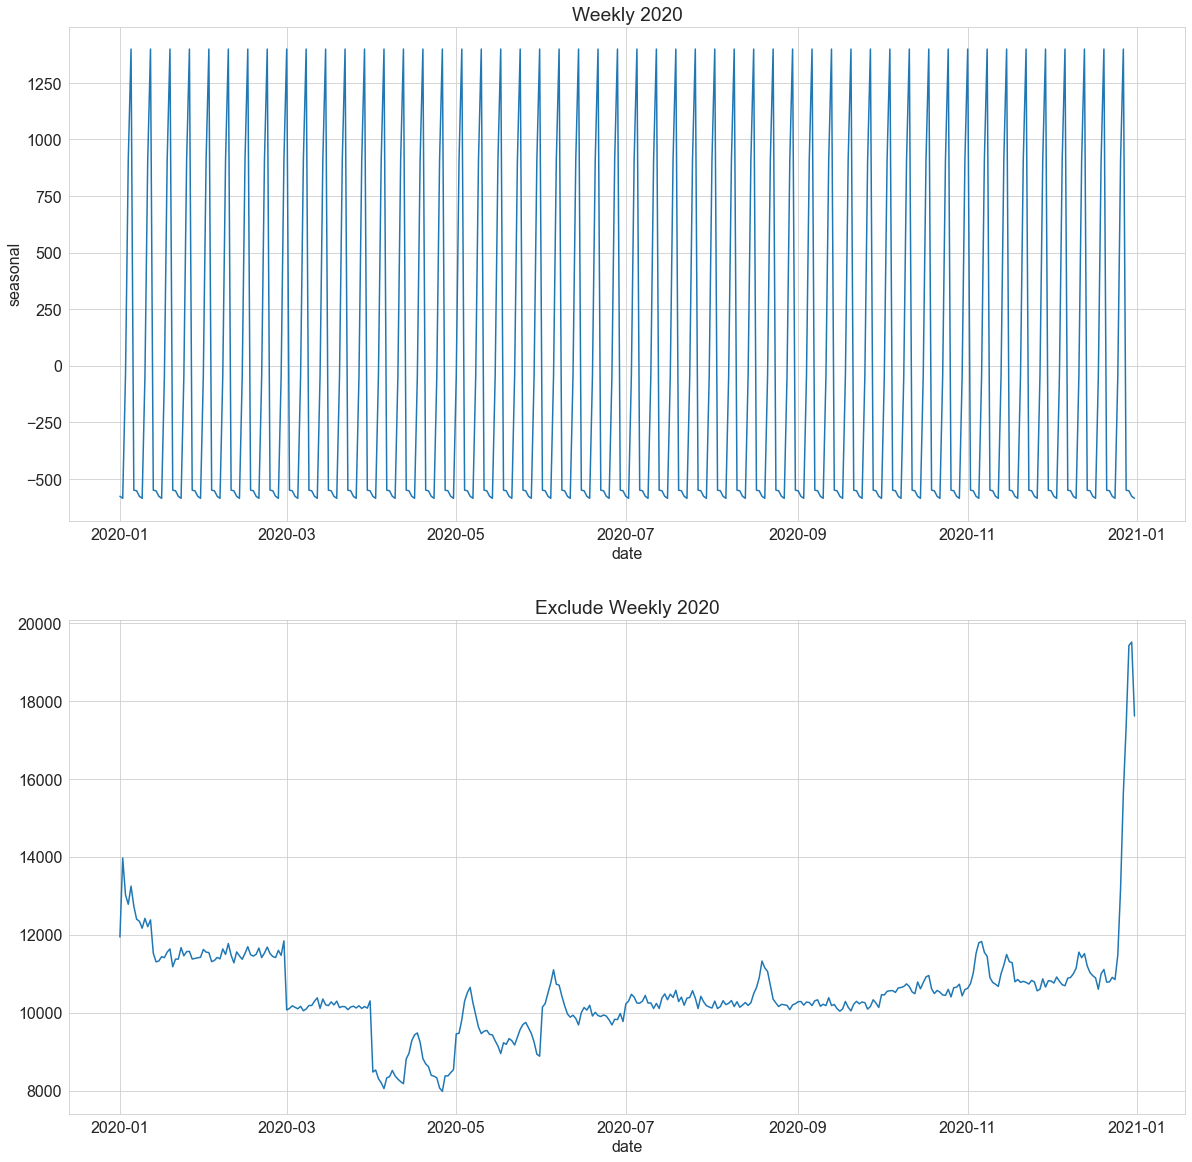

In [27]:
f, ax = plt.subplots(2, 1, figsize=(20,20))
ax[0].set_title('Weekly 2020')
ax[1].set_title('Exclude Weekly 2020')
sns.lineplot(ax=ax[0], data = seasonal_decomp20.seasonal, x="date", y=seasonal_decomp20.seasonal)
sns.lineplot(ax=ax[1], data = exc_weekly20, x="date", y=exc_weekly20)

<AxesSubplot:title={'center':'Exclude Weekly 2020'}, xlabel='date'>

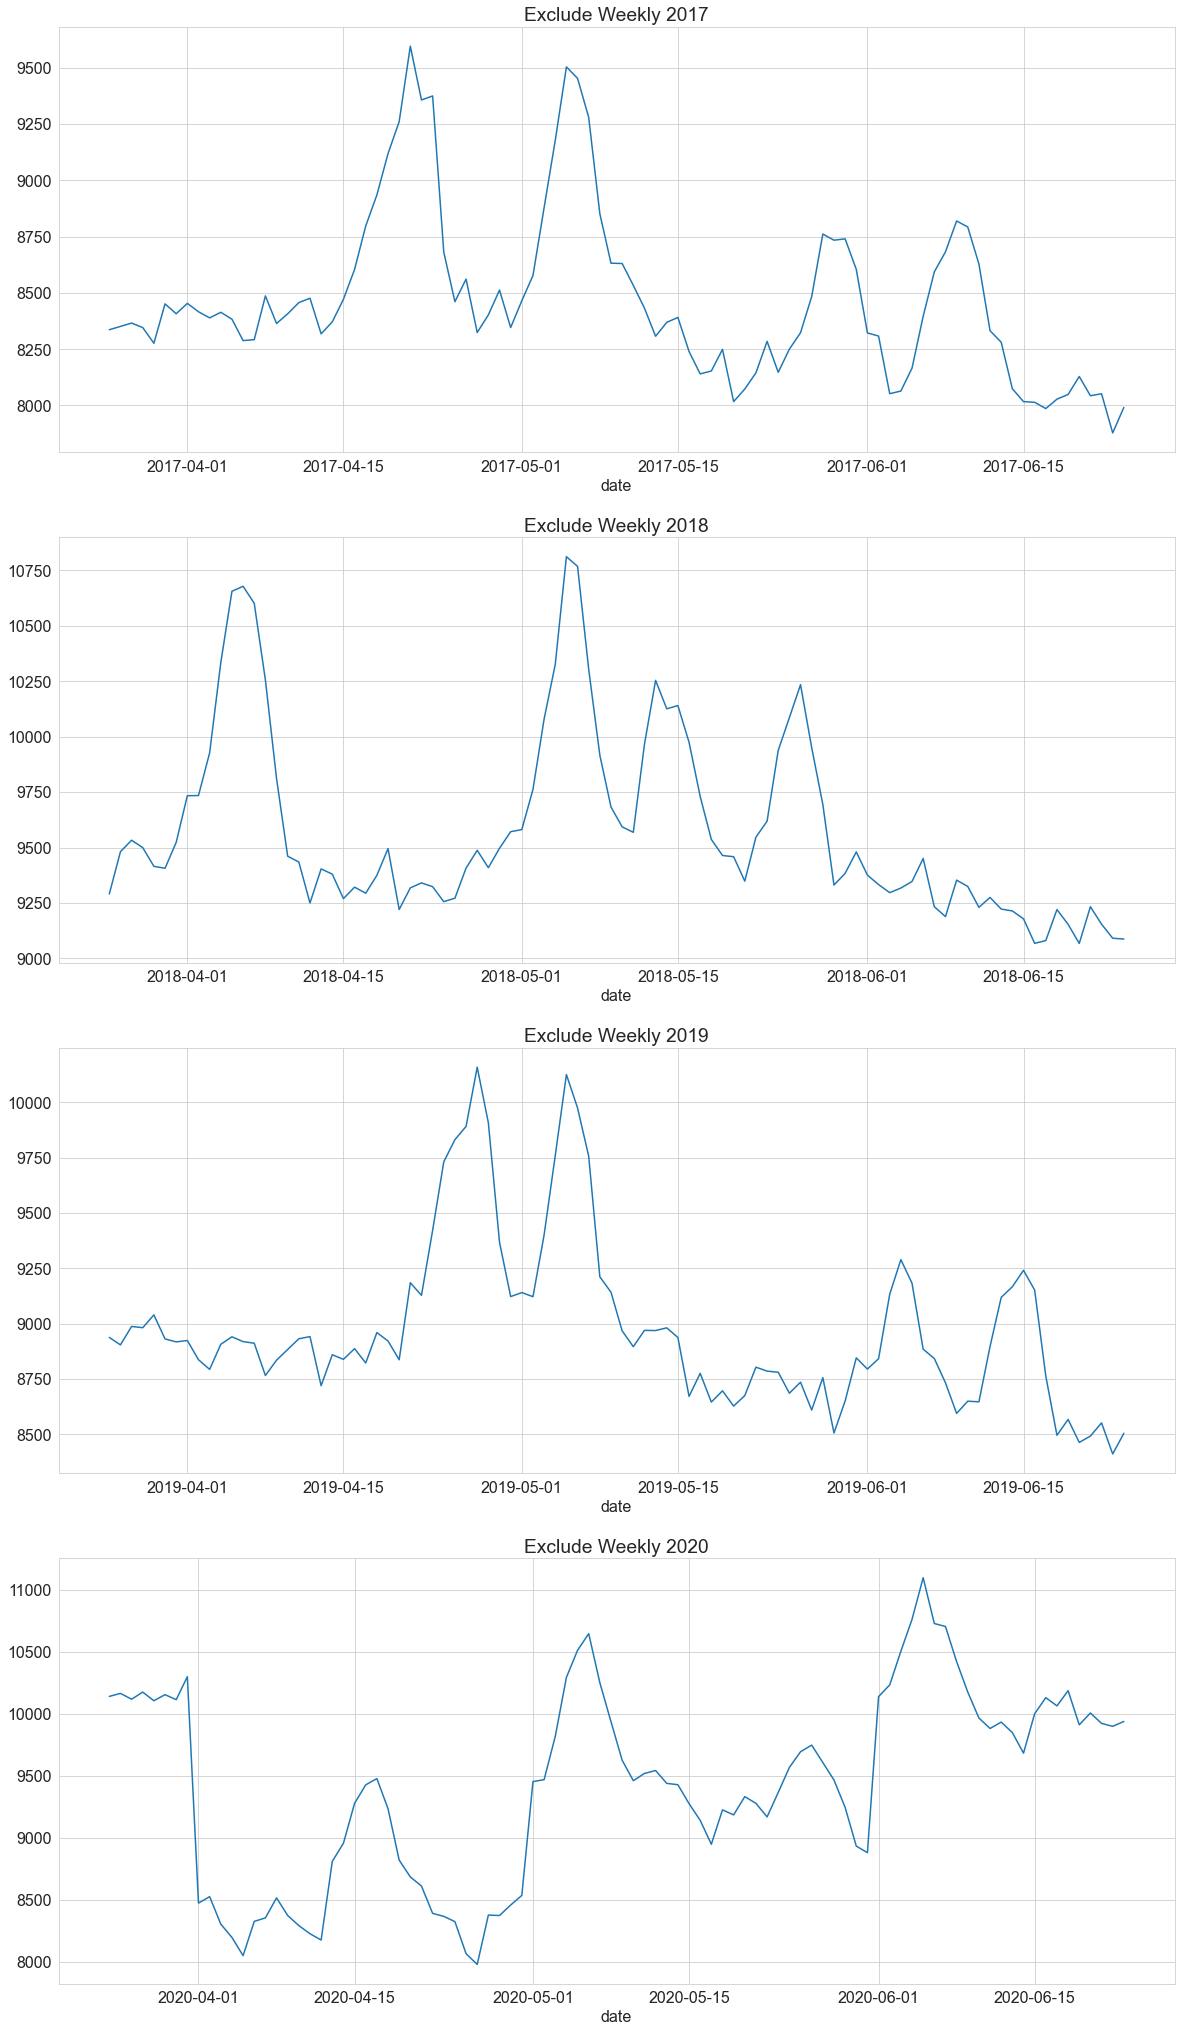

In [28]:
f, ax = plt.subplots(4, 1, figsize=(20,36))
ax[0].set_title('Exclude Weekly 2017')
ax[1].set_title('Exclude Weekly 2018')
ax[2].set_title('Exclude Weekly 2019')
ax[3].set_title('Exclude Weekly 2020')
sns.lineplot(ax=ax[0], data = exc_weekly17[83:175], x="date", y=exc_weekly17)
sns.lineplot(ax=ax[1], data = exc_weekly18[83:175], x="date", y=exc_weekly18)
sns.lineplot(ax=ax[2], data = exc_weekly19[83:175], x="date", y=exc_weekly19)
sns.lineplot(ax=ax[3], data = exc_weekly20[83:175], x="date", y=exc_weekly20)

1) The first peak in April is one week after Good Friday

2) The second peak is constant at 5-6th of May

3) The third peak is usually at Sunday after Ascention Thursday

4) The fourth peak is 13 days after the third one

# Create time-series for 2021

<AxesSubplot:>

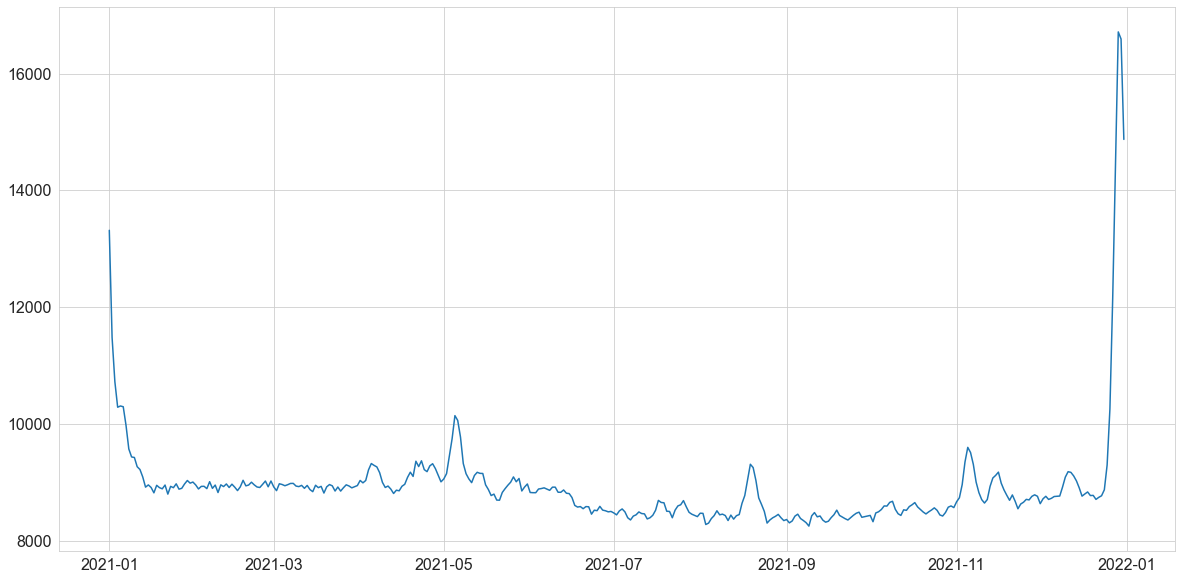

In [29]:
exc_weekly21 = pd.Series((exc_weekly17.values+exc_weekly18.values+exc_weekly19.values)/3, index = test_df.date.unique())

f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=exc_weekly21)

1) Easter

In [30]:
easter17 = exc_weekly17[103:117].values
easter18 = exc_weekly18[88:102].values
easter19 = exc_weekly19[108:122].values
easter19[-1] = easter19[0]
easter19[-2] = easter19[1]
easter21 = (easter17+easter18+easter19) / 3
easter21

array([ 8899.8150414 ,  8943.81349719,  9174.1417131 ,  9219.75609218,
        9427.63657771,  9727.46339305,  9915.37368537, 10054.48170807,
       10038.48016386,  9845.47504643,  9286.75609218,  9014.63657771,
        8944.29670843,  8832.00826484])

In [31]:
### Mar 30 : Apr 01 
exc_weekly21[88:91] = (exc_weekly17[88:91].values+exc_weekly19[88:91].values+exc_weekly18[104:107].values) / 3

In [32]:
### Apr 02 : Apr 15
exc_weekly21[91:105] = easter21

In [33]:
### Apr 16 : Apr 30
exc_weekly21[105:120] = (exc_weekly17[90:105].values+exc_weekly18[105:120].values+exc_weekly19[90:105].values) / 3

2) May 5-6th peak is ok

3) and 4) Ascention

In [34]:
ascention17 = exc_weekly17[143:164].values
ascention18 = exc_weekly18[128:149].values
ascention19 = exc_weekly19[148:169].values
ascention21 = (ascention17+ascention18+ascention19) / 3

In [35]:
### May 12 : June 01
exc_weekly21[131:152] = ascention21

In [36]:
### June 02 : June 17
exc_weekly21[152:168] = (np.linspace(exc_weekly17[153], exc_weekly17[167], 16) + \
                        exc_weekly18[152:168].values + \
                        np.linspace(exc_weekly19[159], exc_weekly19[168], 16)) / 3

<AxesSubplot:>

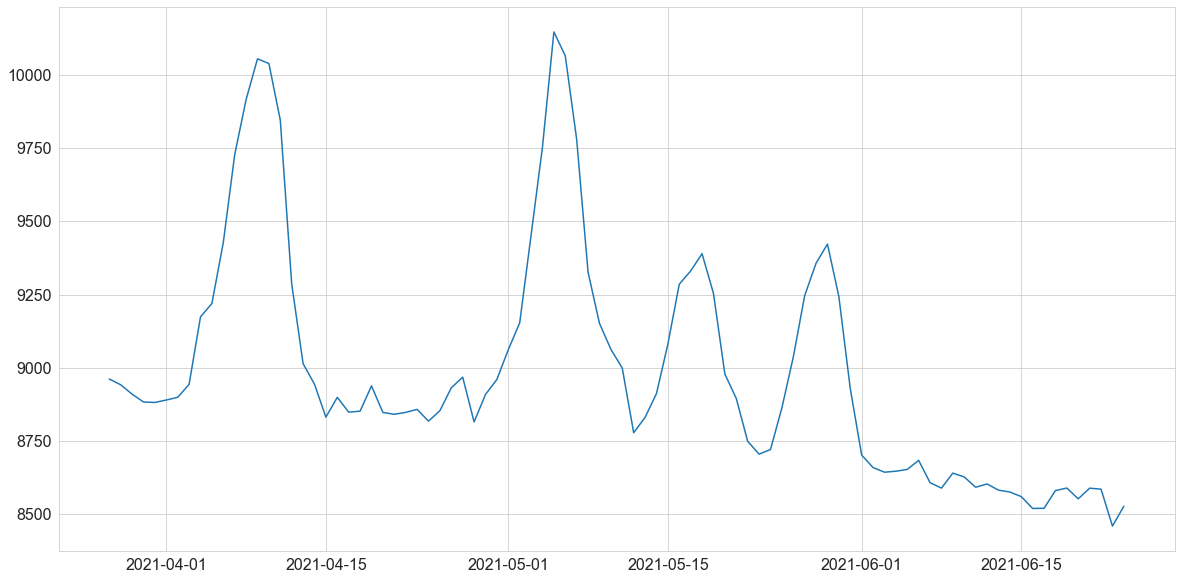

In [37]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=exc_weekly21[85:175])

<AxesSubplot:>

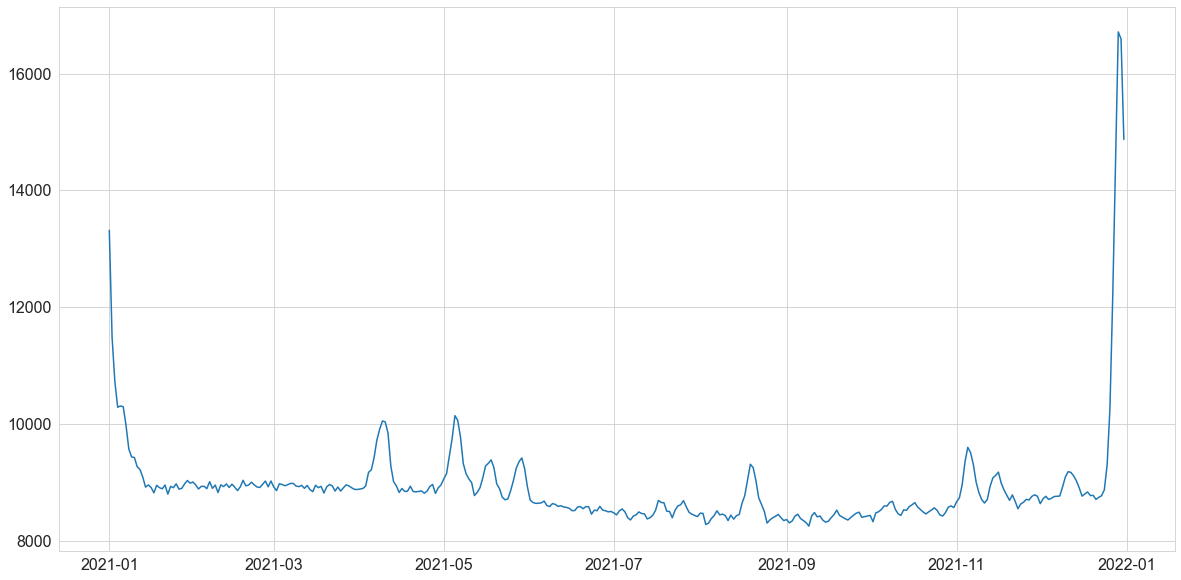

In [38]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=exc_weekly21)

Looks good! Now we add weekly pattern

<AxesSubplot:>

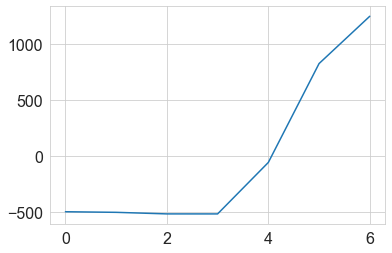

In [39]:
week_avg = (seasonal_decomp20.seasonal[5:12].values + \
            seasonal_decomp19.seasonal[6:13].values + \
            seasonal_decomp18.seasonal[7:14].values + \
            seasonal_decomp17.seasonal[1:8].values \
           ) / 4

sns.lineplot(data=week_avg) 

<AxesSubplot:>

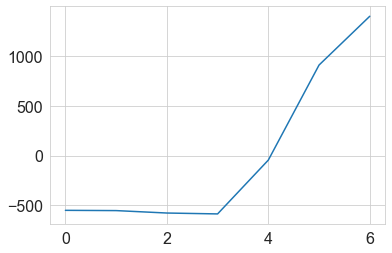

In [40]:
### Using public leaderboard data, we conclude that 2020 weekly pattern gives better score
week_avg = seasonal_decomp20.seasonal[5:12].values

sns.lineplot(data=week_avg) 

In [41]:
pred21 = exc_weekly21 + np.tile(week_avg, 53)[4:369]
pred21

2021-01-01    13273.240468
2021-01-02    12392.721722
2021-01-03    12124.670637
2021-01-04     9740.742659
2021-01-05     9759.292971
                  ...     
2021-12-27    11604.742659
2021-12-28    13874.626304
2021-12-29    16136.667172
2021-12-30    16005.997704
2021-12-31    14828.573801
Length: 365, dtype: float64

In [42]:
### Using public leaderboard data, we conclude that adding 2030 constant gives better score

pred21 = pred21 + 2030
pred21

2021-01-01    15303.240468
2021-01-02    14422.721722
2021-01-03    14154.670637
2021-01-04    11770.742659
2021-01-05    11789.292971
                  ...     
2021-12-27    13634.742659
2021-12-28    15904.626304
2021-12-29    18166.667172
2021-12-30    18035.997704
2021-12-31    16858.573801
Length: 365, dtype: float64

<AxesSubplot:>

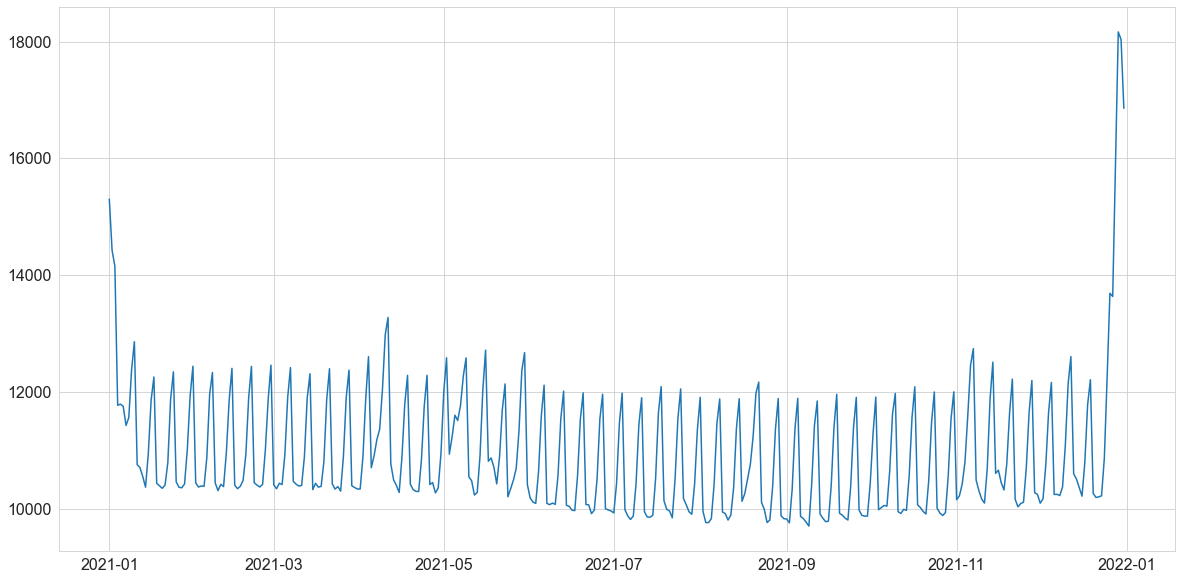

In [43]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=pred21)

<AxesSubplot:>

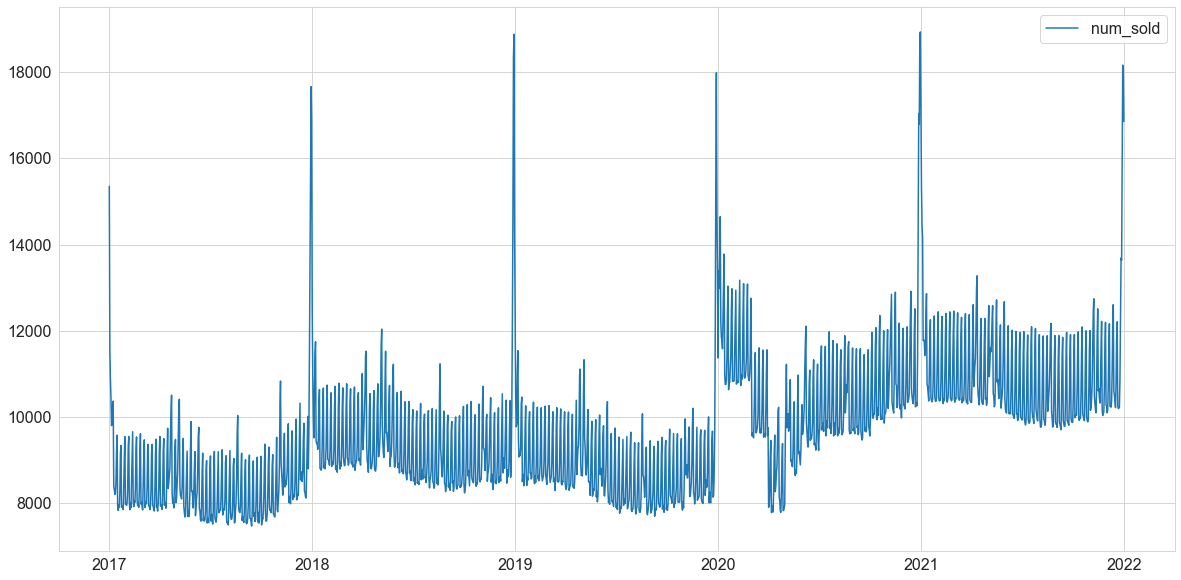

In [44]:
f, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=pd.concat([agg_df.set_index('date'), pd.DataFrame(pred21, columns=['num_sold'])]))

# Make the submission

In [45]:
tpr = pd.melt(
        test_product_ratio_df, ignore_index=False
        )\
        .reset_index()\
        .rename({
                'index':'date', 
                'variable':'product',
                'value':'ratios'}, \
            axis=1)\
        .set_index(["date","product"])
tpr

ratios
date       product                                   
2021-01-01 Kaggle Advanced Techniques        0.283229
2021-01-02 Kaggle Advanced Techniques        0.284160
2021-01-03 Kaggle Advanced Techniques        0.285086
2021-01-04 Kaggle Advanced Techniques        0.286107
2021-01-05 Kaggle Advanced Techniques        0.287092
...                                               ...
2021-12-27 Kaggle for Kids: One Smart Goose  0.305164
2021-12-28 Kaggle for Kids: One Smart Goose  0.305080
2021-12-29 Kaggle for Kids: One Smart Goose  0.305053
2021-12-30 Kaggle for Kids: One Smart Goose  0.305025
2021-12-31 Kaggle for Kids: One Smart Goose  0.305006

[1460 rows x 1 columns]

In [46]:
tcr = pd.melt(
        test_country_ratio_df, ignore_index=False
        )\
        .reset_index()\
        .rename({
                'index':'date', 
                'variable':'country',
                'value':'ratios'}, \
            axis=1)\
        .set_index(["date","country"])
tcr

ratios
date       country          
2021-01-01 Belgium  0.160390
2021-01-02 Belgium  0.163514
2021-01-03 Belgium  0.166591
2021-01-04 Belgium  0.167850
2021-01-05 Belgium  0.168285
...                      ...
2021-12-27 Spain    0.163348
2021-12-28 Spain    0.164100
2021-12-29 Spain    0.163774
2021-12-30 Spain    0.162099
2021-12-31 Spain    0.161336

[2190 rows x 1 columns]

In [47]:
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [48]:
def pred_num_sold(df, preds):
    df = df.set_index('date')
    df['num_sold'] = pd.DataFrame(preds)
    df = df.reset_index().set_index(["date","product"])
    df['tpr'] = tpr.ratios
    df = df.reset_index().set_index(["date","country"])
    df['tcr'] = tcr.ratios
    df = df.reset_index().set_index('store')
    df['tsr'] = store_weights
    df = df.reset_index()
    df['num_sold'] = df['num_sold'] * df['tpr'] * df['tcr'] * df['tsr']
    return df[['row_id','num_sold']]

In [49]:
pred_num_sold(test_df, pred21).to_csv('sub34.csv', index=False)